In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler, DataLoader
from tqdm import tqdm
from PIL import Image

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [11]:
#Creating custom dataset
data_path_train = "C:/Users/M/Desktop/Python/Amber/Data/Train3"
data_path_test = "C:/Users/M/Desktop/Python/Amber/Data/Test3"
IMG_SIZE = 224

transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5)),
        ]
    )

class CustomDataSet():
       
    def __init__(self,data_path,transform=None):
        
        self.transform = transform
        
        self.data_path = data_path
        self.data = dset.ImageFolder(self.data_path)
        self.nrofclass = len(self.data.classes)
                
        self.custom_data = []
        for i in tqdm(range(len(self.data))):
            ImgPath = self.data.samples[i][0]
            img = cv2.imread(ImgPath)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # gray scale for shape 
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            Category = self.data.samples[i][1]
            #y_label = torch.tensor(np.eye(self.nrofclass)[Category]) # one hot encoding
            y_label = torch.tensor(Category)
            self.custom_data.append([img, y_label]) 
            
    def __len__(self):
        return len(self.custom_data)
    
    def __getitem__(self, idx):
        img, class_id = self.custom_data[idx]
        if self.transform is not None:
            img = self.transform(img)
        return (img, class_id)

DataSetTrain = CustomDataSet(data_path_train,transform=transform)
DataSetTest = CustomDataSet(data_path_test,transform=transform)

100%|████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:00<00:00, 2528.51it/s]


In [ ]:
DataSetTrain[500][1]

In [12]:
valid_size = int(0.2 * len(DataSetTest))
test_size = len(DataSetTest) - valid_size
valid_dataset, test_dataset = torch.utils.data.random_split(DataSetTest, [valid_size, test_size])

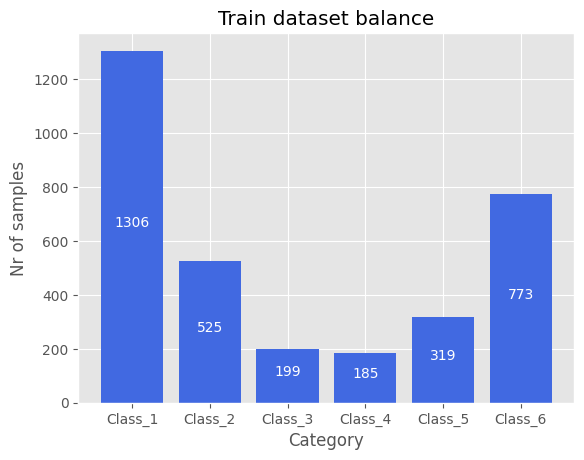

In [32]:
# Checking for class balance
DataSummary = []
class_weights = []
for i in range(len(DataSetTrain.data.classes)):
    count = DataSetTrain.data.targets.count(i)
    DataSummary.append(count)
    
DataBalance = dict(zip(DataSetTrain.data.classes,DataSummary))

Categories = list(DataBalance.keys())
Samples = list(DataBalance.values())

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center', color = 'white')

plt.style.use('ggplot')
plt.title('Train dataset balance')
plt.xlabel('Category')
plt.ylabel('Nr of samples')
plt.bar(Categories,Samples, color = 'royalblue')
addlabels(Categories,Samples)
plt.show()

In [14]:
# Initialise class weights
class_weights = []
for i in range(len(DataSetTrain.data.classes)):
    count = DataSetTrain.data.targets.count(i)
    class_weights.append(1/(count))

sample_weights = [0] * len(DataSetTrain)

for idx, (data, label) in enumerate(DataSetTrain):
        class_weight = class_weights[label.argmax()]
        sample_weights[idx] = class_weight

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [15]:
#Data loaders
BATCH_SIZE = 50
train_data_loader = DataLoader(DataSetTrain, 
                               batch_size=BATCH_SIZE,  
                               #shuffle=True
                               sampler=sampler
                               )

valid_data_loader = DataLoader(valid_dataset, 
                              batch_size=20,  
                             # num_workers=0,
                              shuffle=True
                              )

test_data_loader = DataLoader(test_dataset, 
                              batch_size=20,  
                             # num_workers=0,
                              shuffle=False
                              )

In [16]:
from torchvision.utils import _log_api_usage_once
import torch.nn.init as init

class Fire(nn.Module):
    def __init__(self, inplanes: int, squeeze_planes: int, expand1x1_planes: int, expand3x3_planes: int) -> None:
        super().__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes, kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes, kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat(
            [self.expand1x1_activation(self.expand1x1(x)), self.expand3x3_activation(self.expand3x3(x))], 1
        )


class SqueezeNet(nn.Module):
    def __init__(self, num_classes: int = 6, dropout: float = 0.5) -> None:
        super().__init__()
        _log_api_usage_once(self)
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(64, 16, 64, 64),
            Fire(128, 16, 64, 64),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(128, 32, 128, 128),
            Fire(256, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            Fire(256, 48, 192, 192),
            Fire(384, 48, 192, 192),
            Fire(384, 64, 256, 256),
            Fire(512, 64, 256, 256),
            )

        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout), final_conv, nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal_(m.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)

In [17]:
net = SqueezeNet()
net.to(device)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [19]:
EPOCHS = 50
optimizer = optim.Adam(net.parameters(), lr=1e-3)
loss_function = nn.CrossEntropyLoss()
steps = len(train_data_loader)
stepsv = len(valid_data_loader)
#val_losses = []
#train_losses = []
#val_accs = []
#train_accs = []
for epoch in range(EPOCHS):
    total = 0
    train_acc = 0
    train_loss = 0
    net.train()
    for step in tqdm(range(steps)):
        x, y = next(iter(train_data_loader))
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = net(x)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step() 
        
        total += y.size(0)
        
        _, predicted = outputs.max(1)
  
        train_acc += (predicted == y).sum().cpu().detach().numpy()
        train_loss += loss.item()
        
    acct=100.*train_acc/total
    train_accs.append(acct)
    losst= train_loss/len(train_data_loader)
    train_losses.append(losst)
    
    totalv = 0
    val_acc = 0
    val_loss = 0
    net.eval()
    with torch.no_grad():
        for step in tqdm(range(stepsv)):
            vinputs, vlabels = next(iter(valid_data_loader))
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            voutputs = net(vinputs)
            
            vloss = loss_function(voutputs, vlabels)
            
            totalv += vlabels.size(0)
        
            _, predictedv = voutputs.max(1)
            
            val_acc += (predictedv == vlabels).sum().cpu().detach().numpy()
            val_loss += vloss.item()
            
    accuv=100.*val_acc/totalv
    val_accs.append(accuv)
    lossv= val_loss/len(valid_data_loader)
    val_losses.append(lossv)
    
    print(f"Epoch: {epoch}. Loss: {losst}. Validation Loss: {lossv}")
    print(f"Train accuracy: {acct}. Validation accuracy: {accuv}")

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.26it/s]


Epoch: 0. Loss: 0.10182565777326252. Validation Loss: 0.8615753731944344
Train accuracy: 96.41791044776119. Validation accuracy: 80.0


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.46it/s]


Epoch: 1. Loss: 0.10354578267060109. Validation Loss: 0.4815442318266088
Train accuracy: 96.32835820895522. Validation accuracy: 85.45454545454545


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.58it/s]


Epoch: 2. Loss: 0.10428430394394629. Validation Loss: 0.5965218083425001
Train accuracy: 95.88059701492537. Validation accuracy: 81.36363636363636


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.93it/s]


Epoch: 3. Loss: 0.07023020380579714. Validation Loss: 1.2855054627765308
Train accuracy: 97.3731343283582. Validation accuracy: 80.0


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.28it/s]


Epoch: 4. Loss: 0.10378634757292804. Validation Loss: 0.9295423139225353
Train accuracy: 95.97014925373135. Validation accuracy: 78.18181818181819


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.35it/s]


Epoch: 5. Loss: 0.09056289585084835. Validation Loss: 0.90468123013323
Train accuracy: 96.68656716417911. Validation accuracy: 81.36363636363636


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.28it/s]


Epoch: 6. Loss: 0.09096458555657917. Validation Loss: 0.7852641289884393
Train accuracy: 96.50746268656717. Validation accuracy: 79.54545454545455


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.69it/s]


Epoch: 7. Loss: 0.10385807956666199. Validation Loss: 0.4265517070889473
Train accuracy: 96.23880597014926. Validation accuracy: 87.72727272727273


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.93it/s]


Epoch: 8. Loss: 0.09028789963323011. Validation Loss: 1.0255793441425671
Train accuracy: 96.68656716417911. Validation accuracy: 77.27272727272727


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.68it/s]


Epoch: 9. Loss: 0.07148302433345077. Validation Loss: 1.099933610721068
Train accuracy: 97.43283582089552. Validation accuracy: 77.72727272727273


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.40it/s]


Epoch: 10. Loss: 0.07053267448417731. Validation Loss: 0.6954781467264349
Train accuracy: 97.5223880597015. Validation accuracy: 82.72727272727273


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.52it/s]


Epoch: 11. Loss: 0.08435100798300509. Validation Loss: 0.7491954700513319
Train accuracy: 97.04477611940298. Validation accuracy: 82.27272727272727


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.52it/s]


Epoch: 12. Loss: 0.08947202412467171. Validation Loss: 0.5434223846955732
Train accuracy: 97.19402985074628. Validation accuracy: 85.9090909090909


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.28it/s]


Epoch: 13. Loss: 0.08529327030696754. Validation Loss: 0.8340859447013248
Train accuracy: 96.8955223880597. Validation accuracy: 81.36363636363636


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.16it/s]


Epoch: 14. Loss: 0.09299578135763642. Validation Loss: 0.8641629788008603
Train accuracy: 97.01492537313433. Validation accuracy: 80.45454545454545


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.16it/s]


Epoch: 15. Loss: 0.09315984876854207. Validation Loss: 0.7055022784254767
Train accuracy: 96.86567164179104. Validation accuracy: 82.72727272727273


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.76it/s]


Epoch: 16. Loss: 0.0766047158820638. Validation Loss: 0.7501543922857805
Train accuracy: 97.13432835820896. Validation accuracy: 78.18181818181819


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.81it/s]


Epoch: 17. Loss: 0.08670923034591016. Validation Loss: 0.6849920668385245
Train accuracy: 96.74626865671642. Validation accuracy: 81.81818181818181


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.40it/s]


Epoch: 18. Loss: 0.08445470534793253. Validation Loss: 0.947338342666626
Train accuracy: 96.74626865671642. Validation accuracy: 79.54545454545455


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.40it/s]


Epoch: 19. Loss: 0.08490303829798836. Validation Loss: 0.7418908666480671
Train accuracy: 97.25373134328358. Validation accuracy: 79.54545454545455


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.28it/s]


Epoch: 20. Loss: 0.09248121230126317. Validation Loss: 0.9199451479044828
Train accuracy: 96.68656716417911. Validation accuracy: 82.27272727272727


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.47it/s]


Epoch: 21. Loss: 0.1115860063999669. Validation Loss: 0.6278727460991252
Train accuracy: 95.85074626865672. Validation accuracy: 81.36363636363636


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.64it/s]


Epoch: 22. Loss: 0.0735301071249727. Validation Loss: 0.9786784540523182
Train accuracy: 97.3731343283582. Validation accuracy: 79.54545454545455


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.25it/s]


Epoch: 23. Loss: 0.09931513371029452. Validation Loss: 1.1099165623838252
Train accuracy: 96.41791044776119. Validation accuracy: 72.72727272727273


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.40it/s]


Epoch: 24. Loss: 0.07429351958571308. Validation Loss: 0.820853897116401
Train accuracy: 97.22388059701493. Validation accuracy: 85.45454545454545


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.90it/s]


Epoch: 25. Loss: 0.08516483035272182. Validation Loss: 0.5512776361270384
Train accuracy: 96.95522388059702. Validation accuracy: 84.0909090909091


 28%|███████████████████████▎                                                          | 19/67 [00:02<00:06,  7.91it/s]


KeyboardInterrupt: 

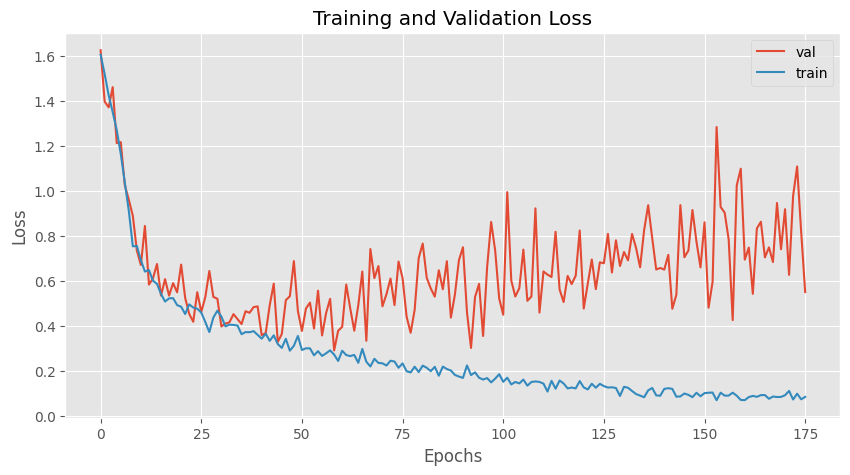

In [33]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

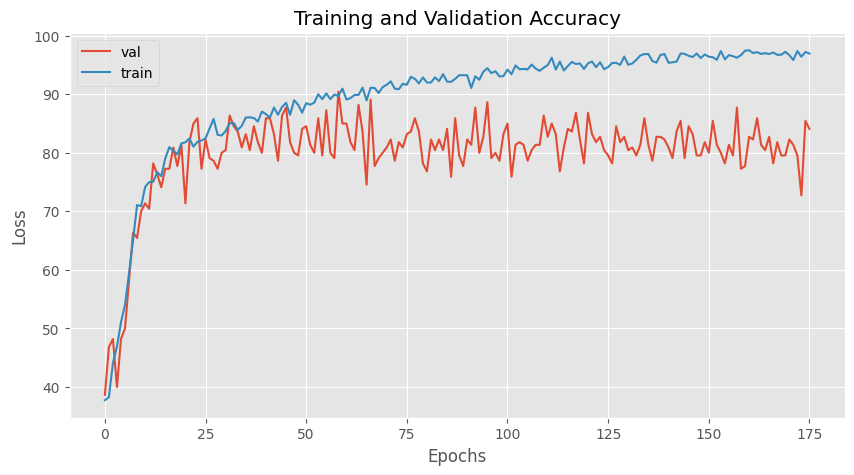

In [34]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accs,label="val")
plt.plot(train_accs,label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# iterate over test data
y_pred = []
y_true = []
correct = 0
net.eval()
net.cpu()
total = 0
with torch.no_grad():
    for inputs, labels in test_data_loader:
           
            output = net(inputs) # Feed Network
            
            pred = output.max(1).indices.to(device)
            
            true = labels.to(device)
            
            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
            
            labels = labels.cpu().numpy()
            y_true.extend(labels) # Save Truth
            
            total += true.size(0)
            correct += torch.sum(pred == true)
# constant for classes
Classes = ('1', '3', '3', '4', '5','6')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

print("Accuracy: ", 100*(correct/total).item())

C:\Users\M\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Accuracy:  85.14739274978638


In [36]:
cf_matrix

array([[316,  19,   0,   3,   0,   9],
       [  8, 133,   2,   0,   0,   1],
       [  1,   3,  36,   2,   2,   9],
       [  0,   0,   0,  45,   0,   3],
       [  0,   0,   5,   0,  74,   6],
       [ 18,   4,  16,   9,  11, 147]], dtype=int64)

Confusion matrix, without normalization
[[316  19   0   3   0   9]
 [  8 133   2   0   0   1]
 [  1   3  36   2   2   9]
 [  0   0   0  45   0   3]
 [  0   0   5   0  74   6]
 [ 18   4  16   9  11 147]]


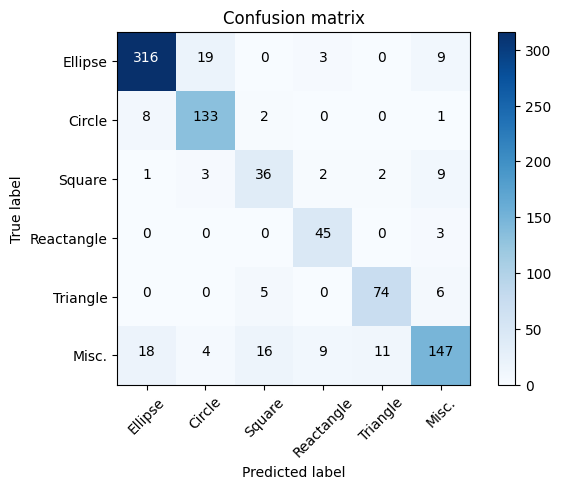

In [37]:
Classes = ('Ellipse', 'Circle', 'Square', 'Reactangle', 'Triangle','Misc.')
plt.style.use('default')
from plotcm import plot_confusion_matrix
plot_confusion_matrix(cf_matrix, Classes)

In [29]:
net.cuda()
from torchsummary import summary
summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 111, 111]           1,792
              ReLU-2         [-1, 64, 111, 111]               0
         MaxPool2d-3           [-1, 64, 55, 55]               0
            Conv2d-4           [-1, 16, 55, 55]           1,040
              ReLU-5           [-1, 16, 55, 55]               0
            Conv2d-6           [-1, 64, 55, 55]           1,088
              ReLU-7           [-1, 64, 55, 55]               0
            Conv2d-8           [-1, 64, 55, 55]           9,280
              ReLU-9           [-1, 64, 55, 55]               0
             Fire-10          [-1, 128, 55, 55]               0
           Conv2d-11           [-1, 16, 55, 55]           2,064
             ReLU-12           [-1, 16, 55, 55]               0
           Conv2d-13           [-1, 64, 55, 55]           1,088
             ReLU-14           [-1, 64,

C:\Users\M\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
